# Automate and funcX

In [3]:
from globus_automate_client import (create_flows_client, graphviz_format, state_colors_for_log,
                                    #get_access_token_for_scope, 
                                    create_action_client, create_flows_client)
from IPython.display import display, display_svg, clear_output
#from ipywidgets import widgets
import time
import json
import sys
import os

from funcx.sdk.client import FuncXClient


sys.path.append(".")
os.environ['JUPYTER_PATH'] = '.'
CLIENT_ID = "e6c75d97-532a-4c88-b031-8584a319fa3e"

## funcX

This is an example of using funcX. This defines a simple hello-world function, registers it with funcX, then calls it.


In [4]:
fxc = FuncXClient()

In [5]:
def funcx_hello(event):
    import time
#     time.sleep(20)
    name = event['name']
    return f"Hello, {name}"

func_uuid = fxc.register_function(funcx_hello,
                                  description="A hello dict function")
print(func_uuid)

2de2a152-3a71-4b5a-8247-ecda241ce2bd


### Test the funcX function

In [6]:
payload = {'name': "Ryan"}

endpoint_uuid = '4b116d3c-1703-4f8f-9f6f-39921e5864df'

In [7]:
res = fxc.run(payload, endpoint_id=endpoint_uuid, function_id=func_uuid)
print(res)

033e1249-bc5e-480a-bb4f-bbf95b23e180


In [8]:
fxc.get_result(res)

'Hello, Ryan'

### Now create a one step flow using funcx

In [9]:
flow_definition = {
  "Comment": "Automate funcX",
  "StartAt": "funcx",
  "States": {
    "funcx": {
      "Comment": "run funcX",
      "Type": "Action",
      "ActionUrl": "https://api.funcx.org/automate",
      "ActionScope": "https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2",
      "InputPath": "$.Exec1Input",
      "ResultPath": "$.Exec1Result",
      "WaitTime": 1000,
      "End": True
    }
  }
}

In [10]:
flows_client = create_flows_client(CLIENT_ID)
flow = flows_client.deploy_flow(flow_definition, title="test funcx")
flow_id = flow['id']
print(flow)
flow_scope = flow['globus_auth_scope']
print(f'Newly created flow with id:\n{flow_id}\nand scope:\n{flow_scope}')

GlobusHTTPResponse({'action_url': 'https://flows.globus.org/flows/6313ba4c-45d6-4327-af14-fab275bd2cea', 'administered_by': [], 'api_version': '1.0', 'definition': {'Comment': 'Automate funcX', 'StartAt': 'funcx', 'States': {'funcx': {'ActionScope': 'https://auth.globus.org/scopes/facd7ccc-c5f4-42aa-916b-a0e270e2c2a9/automate2', 'ActionUrl': 'https://api.funcx.org/automate', 'Comment': 'run funcX', 'End': True, 'InputPath': '$.Exec1Input', 'ResultPath': '$.Exec1Result', 'Type': 'Action', 'WaitTime': 1000}}}, 'description': '', 'globus_auth_scope': 'https://auth.globus.org/scopes/6313ba4c-45d6-4327-af14-fab275bd2cea/flow_6313ba4c_45d6_4327_af14_fab275bd2cea_user', 'globus_auth_username': '6313ba4c-45d6-4327-af14-fab275bd2cea@clients.auth.globus.org', 'id': '6313ba4c-45d6-4327-af14-fab275bd2cea', 'keywords': [], 'log_supported': True, 'principal_urn': 'urn:globus:auth:identity:6313ba4c-45d6-4327-af14-fab275bd2cea', 'runnable_by': [], 'subtitle': '', 'synchronous': False, 'title': 'test f

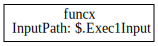

In [11]:
get_resp = flows_client.get_flow(flow_id)
flow_def = get_resp.data['definition']
flow_graph = graphviz_format(flow_def)
display(flow_graph)

In [12]:
payload = {'name':'Hello'}

In [13]:
flow_input = {
  "Exec1Input": {
      "tasks": [{
         "endpoint": endpoint_uuid,
         "func": func_uuid,
         "payload": payload}],
  }
}


In [14]:
print(flow_input)

{'Exec1Input': {'tasks': [{'endpoint': '4b116d3c-1703-4f8f-9f6f-39921e5864df', 'func': '2de2a152-3a71-4b5a-8247-ecda241ce2bd', 'payload': {'name': 'Hello'}}]}}


In [15]:
flow_action = flows_client.run_flow(flow_id, flow_scope, flow_input)
print(flow_action)
flow_action_id = flow_action['action_id']
flow_status = flow_action['status']
print(f'Flow action started with id: {flow_action_id}')
while flow_status == 'ACTIVE':
    time.sleep(10)
    flow_action = flows_client.flow_action_status(flow_id, flow_scope, flow_action_id)
    flow_status = flow_action['status']
    print(f'Flow status: {flow_status}')

Starting login with Globus Auth, press ^C to cancel.
GlobusHTTPResponse({'action_id': 'e4bf56d2-d7bb-4e10-b463-a682b240eafa', 'completion_time': 'None', 'created_by': 'urn:globus:auth:identity:a478e9c0-d274-11e5-9901-63aaec352b80', 'details': {'code': 'ActionStarted', 'description': 'State funcx of type Action started', 'details': {'input': {'tasks': [{'endpoint': '4b116d3c-1703-4f8f-9f6f-39921e5864df', 'func': '2de2a152-3a71-4b5a-8247-ecda241ce2bd', 'payload': {'name': 'Hello'}}]}, 'state_name': 'funcx', 'state_type': 'Action'}, 'time': '2021-02-04T15:44:16.386000+00:00'}, 'start_time': '2021-02-04T15:44:16.347000+00:00', 'status': 'ACTIVE'})
Flow action started with id: e4bf56d2-d7bb-4e10-b463-a682b240eafa
Flow status: SUCCEEDED


In [16]:
flow_action

GlobusHTTPResponse({'action_id': 'e4bf56d2-d7bb-4e10-b463-a682b240eafa', 'completion_time': '2021-02-04T15:44:23.374000+00:00', 'created_by': 'urn:globus:auth:identity:a478e9c0-d274-11e5-9901-63aaec352b80', 'details': {'output': {'Exec1Input': {'tasks': [{'endpoint': '4b116d3c-1703-4f8f-9f6f-39921e5864df', 'func': '2de2a152-3a71-4b5a-8247-ecda241ce2bd', 'payload': {'name': 'Hello'}}]}, 'Exec1Result': {'action_id': 'ab57bc14-bf3c-4a5a-b954-44351b3550e1', 'details': {'completion_t': '1612453462.8109565', 'exception': None, 'result': 'Hello, Hello', 'status': 'SUCCEEDED', 'task_id': 'ab57bc14-bf3c-4a5a-b954-44351b3550e1'}, 'release_after': 'P30D', 'state_name': 'funcx', 'status': 'SUCCEEDED'}}}, 'start_time': '2021-02-04T15:44:16.347000+00:00', 'status': 'SUCCEEDED'})

In [17]:
flow_action['details']['output']#['Exec1Result']['details']['result']

{'Exec1Input': {'tasks': [{'endpoint': '4b116d3c-1703-4f8f-9f6f-39921e5864df',
    'func': '2de2a152-3a71-4b5a-8247-ecda241ce2bd',
    'payload': {'name': 'Hello'}}]},
 'Exec1Result': {'action_id': 'ab57bc14-bf3c-4a5a-b954-44351b3550e1',
  'details': {'completion_t': '1612453462.8109565',
   'exception': None,
   'result': 'Hello, Hello',
   'status': 'SUCCEEDED',
   'task_id': 'ab57bc14-bf3c-4a5a-b954-44351b3550e1'},
  'release_after': 'P30D',
  'state_name': 'funcx',
  'status': 'SUCCEEDED'}}

In [18]:
import globus_automate_client

In [19]:
globus_automate_client.__version__

'0.10.5'